In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torchvision
from tqdm import tqdm_notebook
import torchvision.transforms as transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from tqdm import tqdm

import pdb

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# rc('text', usetex=True)

## Loading the dataset

In [4]:
batch_size = 20

In [5]:
'''
Loads MNIST dataset
'''
def binarize(x):
    D.Bernoulli(torch.tensor([x]))
    return (x>0.0).float()

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(binarize)])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
torch.utils.data.Dataset(trainset, ge)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

# class_names = tuple(str(i) for i in range(10))

In [99]:
'''
Loads FashionMNIST dataset
'''
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
torch.utils.data.Dataset()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

# class_names = tuple(str(i) for i in range(10))

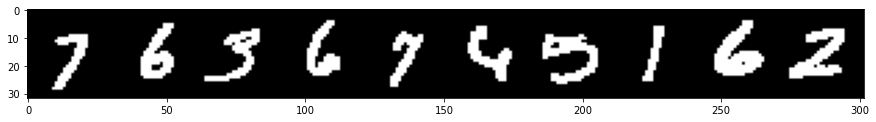

In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(15,10))
imshow(torchvision.utils.make_grid(images[:10], nrow=10))
plt.show()

In [92]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [93]:
device

'cuda'

## Model parameters

In [94]:
class VAE(nn.Module):
    def __init__(self, hidden_dim):
        super(VAE, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(nn.Linear(784,392),
                                     nn.ELU(),
                                     nn.Linear(392, 196),
                                     nn.ELU())
        
        self.hidden_mu = nn.Linear(196, self.hidden_dim)
        self.hidden_log_var = nn.Linear(196, self.hidden_dim)
        
        self.decoder = nn.Sequential(nn.Linear(self.hidden_dim, 196),
                                     nn.ELU(),
                                     nn.Linear(196, 392),
                                     nn.ELU(),
                                     nn.Linear(392, 784),
                                     nn.Sigmoid())
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden_mu(hidden)
        log_var = self.hidden_log_var(hidden)
        return mu, log_var

    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        z = torch.randn_like(std) # get normal distribution size of sigma
        return mu + z*std
    
    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        hidden = self.reparametrize(mu, log_var) # bottleneck
        output = self.decoder(hidden) # x_out
        return mu, log_var, output

In [38]:
hidden_dim = 64
net = VAE(hidden_dim)
optimizer = torch.optim.Adam(params = net.parameters())
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)
history = {'train':[], 'test':[]}

PATH = "pretrained/vanilla_vae_mnist.pth"
checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history['train'] = checkpoint['train_loss']
history['test'] = checkpoint['test_loss']

net.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
  )
  (hidden_mu): Linear(in_features=392, out_features=64, bias=True)
  (hidden_log_var): Linear(in_features=392, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

## Training and testing

In [95]:
def loss_fn(mu, log_var, x_out, x):
    kl_loss = -0.5 * torch.sum( 1 + log_var - mu**2 - torch.exp(log_var))
    recon_loss = F.binary_cross_entropy(x_out, x.view(-1, 784), reduction='sum')
    loss = recon_loss + kl_loss
    return loss

In [96]:
def train(epoch):
    net.train()
    running_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm_notebook(trainloader)):
        optimizer.zero_grad()
        mu, log_var, x_out = net(data)
        loss = loss_fn(mu, log_var, x_out, data)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        if batch_idx % (log_interval*6) == 0:
            history['train'].append(loss.item()/len(data))
    print("===> Epoch: {}/{} Average train loss: {:.4f}".format(epoch, num_epochs, running_loss/len(trainloader.dataset)))
    
def test(epoch):
    net.eval()
    running_loss = 0
    for batch_idx, (data, _) in enumerate(testloader):
        with torch.no_grad():
            mu, log_var, x_out = net(data)
            loss = loss_fn(mu, log_var, x_out, data)
            running_loss += loss.item()
            if batch_idx % log_interval == 0:
                history['test'].append(loss.item()/len(data))
    print("===> Test set loss: {:.4f}".format(running_loss/len(testloader.dataset)))

if __name__ == "__main__":
    num_epochs = 18
    log_interval = 50
    history = {'train':[], 'test':[]}
    hidden_dim = 28
    net = VAE(hidden_dim)
    optimizer = torch.optim.Adam(params = net.parameters())
    for epoch in range(1, num_epochs+1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, hidden_dim) # 'output' of the bottleneck
            sample = net.decode(sample)
            save_image(sample.view(64, 1, 28, 28), 'vae_results/sample_' + str(epoch) + '.png')

  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 1/18 Average train loss: 125.3123
===> Test set loss: 99.5005


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 2/18 Average train loss: 95.9806
===> Test set loss: 91.8287


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 3/18 Average train loss: 91.4478
===> Test set loss: 88.5649


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 4/18 Average train loss: 89.0104
===> Test set loss: 87.8843


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 5/18 Average train loss: 87.4914
===> Test set loss: 85.8597


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 6/18 Average train loss: 86.3510
===> Test set loss: 86.9861


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 7/18 Average train loss: 85.6197
===> Test set loss: 86.4483


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 8/18 Average train loss: 84.9761
===> Test set loss: 84.2540


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 9/18 Average train loss: 84.3209
===> Test set loss: 84.5985


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 10/18 Average train loss: 83.8104
===> Test set loss: 84.1216


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 11/18 Average train loss: 83.4340
===> Test set loss: 83.7256


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 12/18 Average train loss: 83.0569
===> Test set loss: 84.1628


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 13/18 Average train loss: 82.6006
===> Test set loss: 82.1427


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 14/18 Average train loss: 82.3687
===> Test set loss: 84.4750


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 15/18 Average train loss: 82.0429
===> Test set loss: 83.0907


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 16/18 Average train loss: 81.8307
===> Test set loss: 82.6630


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 17/18 Average train loss: 81.5890
===> Test set loss: 81.4491


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 18/18 Average train loss: 81.2729
===> Test set loss: 81.8007


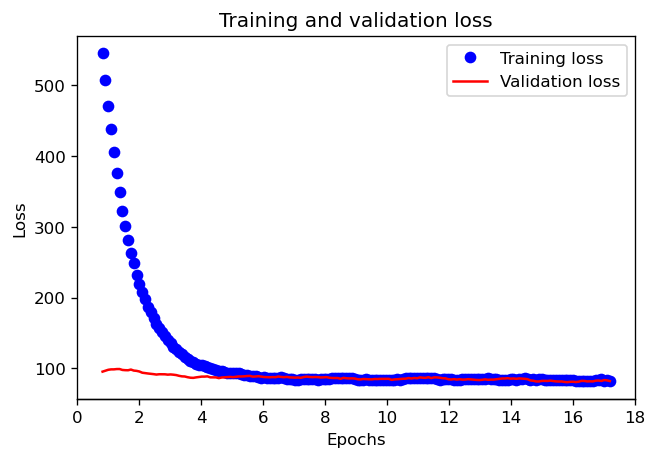

In [97]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def forward(x):
    return np.array(list(map(lambda t: int(t/10), x)))

def inverse(x):
    return x * 10

def plot_losses(history):
    loss_values = smooth_curve(history['train'])
    val_loss_values = smooth_curve(history['test'])
    epochs = np.arange(len(loss_values))
    fig, ax = plt.subplots(1,1,figsize=(6,4), dpi=120)
    ax.plot(epochs, loss_values, 'bo', label='Training loss')
    ax.plot(epochs, val_loss_values, 'r', label='Validation loss')
    epoch = np.arange(1,19)
    secax = ax.secondary_xaxis('bottom', functions=(forward, inverse))
    secax.set_xlabel('Epochs')
    ax.get_xaxis().set_visible(False)
  
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(history)

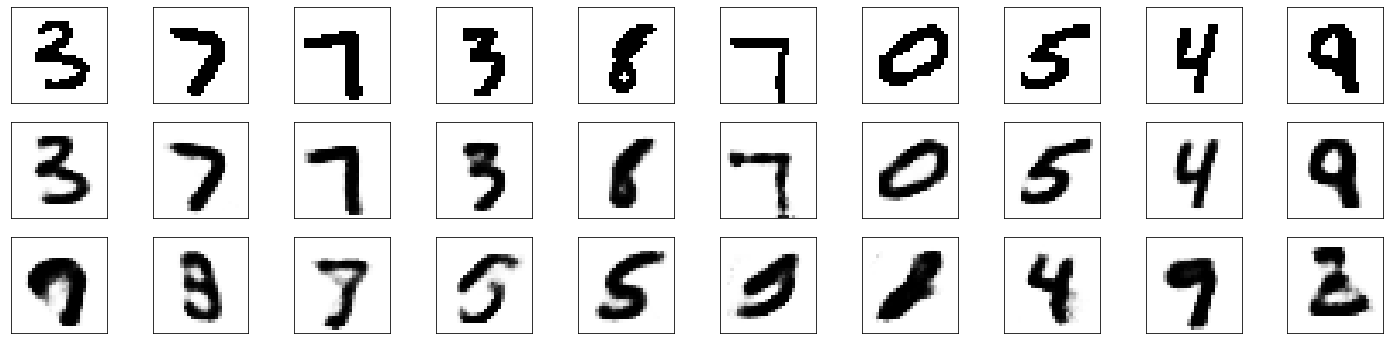

In [98]:
def example10(model, dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()

    images_flatten = images.view(images.size(0), -1)
    _, __, recon = model(images_flatten)
    sample = torch.randn(10, model.hidden_dim)
    gen = model.decode(sample)

    images = images.numpy()[:10]
    recon = recon.view(batch_size, 1, 28, 28).detach().numpy()[:10]
    gen = gen.view(10, 1, 28, 28).detach().numpy()

    fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25,6))

    for images, row in zip([images, recon, gen], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='binary')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
example10(net, testloader)

## Saving new parameters

In [15]:
PATH = "pretrained/vanilla_vae_mnist.pth"
torch.save({
            'epoch': num_epochs,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': history['train'],
            'test_loss': history['test'],
            }, PATH)

In [31]:
x = torch.tensor([[3,4,5],[6,7,9]])

In [43]:
map(x/100, D.Bernoulli())

ValueError: Either `probs` or `logits` must be specified, but not both.